In [79]:
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from ripser import ripser
from sklearn.decomposition import PCA
import os

In [80]:
# Construct adjacency matrix

def construct_adjacency_matrix(game_data):
    G = nx.Graph()

    # Step 1: Find the maximum pass count to normalize edge weights
    max_count = max(pass_info["count"] for player in game_data for pass_info in player["passes"])

    # Step 2: Add nodes for each player
    for player in game_data:
        G.add_node(player['name'], pos=(player['x'], player['y']))
    
    # Step 3: Add edges with normalized weights (divide by max_count)
    for player in game_data:
        for pass_info in player["passes"]:
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]
            # Normalize edge weight by dividing by the max pass count
            edge_weight = count / max_count

            # Add edge to the graph with normalized weight
            G.add_edge(player1, player2, weight=edge_weight)

    return G

In [81]:
# Load the data from the files

'''file_paths = ['/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890259_Bayern-Munich_2_55.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890259_Hamburger-SV_0_59.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890260_Bayer-Leverkusen_1_59.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890260_Hoffenheim_1_57.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890261_Borussia-Dortmund_4_76.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890261_Borussia-Mönchengladbach_0_64.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890262_Darmstadt-98_2_64.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890262_Hannover-96_0_45.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890263_FSV-Mainz-05_0_73.json', 
    '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/3890263_Ingolstadt_0_60.json'
]
'''
folder_path = '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/'

# Get a list of all files in the folder
file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith('.json')]

# Load all files
data = [json.load(open(file_path)) for file_path in file_paths]

In [82]:
# Construct the passing network for each match and compute persistence diagrams
persistence_diagrams = []
for match_data in data:
    G = construct_adjacency_matrix(match_data)  # Construct adjacency matrix for each team
    adj_matrix = nx.to_numpy_array(G)  # Convert the graph to an adjacency matrix
    persistence_diagrams.append(ripser(adj_matrix, distance_matrix=True)['dgms'])  # Compute persistence diagram

In [83]:
# Extract features from persistence diagrams
def extract_features(persistence_diagrams):
    features = []
    max_len = 0
    
    # First, calculate the maximum length of any feature vector
    for diagram in persistence_diagrams:
        if diagram:  # If the diagram is not empty
            diagram = np.array(diagram[0])  # Diagram[0] contains the points
            lifespan = diagram[:, 1] - diagram[:, 0]  # Calculate lifespan (death - birth)
            features.append(lifespan)
            max_len = max(max_len, len(lifespan))  # Track the maximum length
        else:
            features.append(np.zeros(1))  # In case the diagram is empty, append a zero vector
    
    # Now, pad all features to the maximum length
    padded_features = []
    for feature in features:
        if len(feature) < max_len:
            # Pad with zeros to make the feature vector the same length
            padded_features.append(np.pad(feature, (0, max_len - len(feature)), mode='constant'))
        else:
            padded_features.append(feature)
    
    return np.array(padded_features)

# Extract features from persistence diagrams
features = extract_features(persistence_diagrams)

Features contain NaN or Infinity values.


/Users/lliu001/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


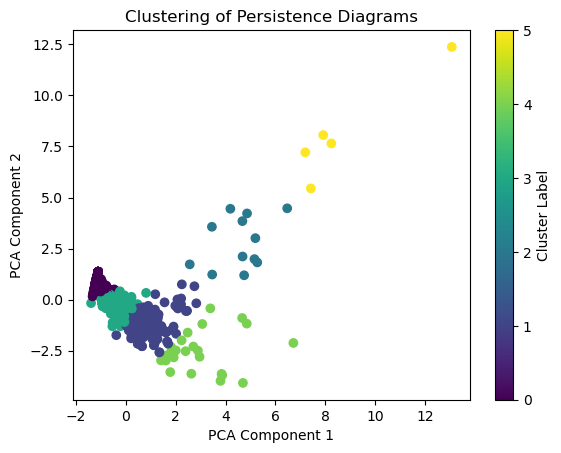

In [84]:
# Standardize the features
scaler = StandardScaler()

# Check for NaN or infinity values in the features
if np.any(np.isnan(features)) or np.any(np.isinf(features)):
    print("Features contain NaN or Infinity values.")
    # Option 1: Replace NaN or infinity with a constant, e.g., the mean or 0
    features = np.nan_to_num(features, nan=0, posinf=0, neginf=0)

    # Option 2: Alternatively, you can replace with the mean or drop problematic rows (depending on your choice)
    # For example:
    # features = np.nan_to_num(features, nan=np.nanmean(features), posinf=0, neginf=0)

# Scale the features now that we have handled NaN or Infinity values
features_scaled = scaler.fit_transform(features)

# Step 4: Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
features_pca = pca.fit_transform(features_scaled)

# Step 5: Perform clustering (KMeans or Agglomerative Clustering)
# Using KMeans as an example
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(features_pca)

# Visualizing the clustering results
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title("Clustering of Persistence Diagrams")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster Label")
plt.show()

# Each cluster represents a different set of persistence diagrams with similar topological properties

In [85]:
# Function to extract goals and time from the filename
def extract_goals_and_time(filename):
    # Assuming the format is "ID_Team_Name_goals_time.json"
    parts = filename.split('_')
    goals = int(parts[2])  # Goals scored
    time = int(parts[3].split('.')[0])  # Time in minutes
    return goals, time

# Function to normalize goals based on time (goal per 60 minutes)
def normalize_goals(goals, time):
    return goals * (60 / time)

# Calculate average goals for each cluster
def calculate_average_goals(cluster_labels, filenames):
    cluster_goals = {}
    
    for idx, filename in enumerate(filenames):
        goals, time = extract_goals_and_time(filename)
        normalized_goals = normalize_goals(goals, time)
        
        cluster_id = cluster_labels[idx]
        
        if cluster_id not in cluster_goals:
            cluster_goals[cluster_id] = {'total_goals': 0, 'count': 0}
        
        cluster_goals[cluster_id]['total_goals'] += normalized_goals
        cluster_goals[cluster_id]['count'] += 1
    
    average_goals = {}
    for cluster_id, data in cluster_goals.items():
        average_goals[cluster_id] = data['total_goals'] / data['count']
    
    return average_goals

# Get the average goals for each cluster
average_goals = calculate_average_goals(cluster_labels, file_paths)

# Print the average goals for each cluster
for cluster_id, avg_goals in average_goals.items():
    print(f"Cluster {cluster_id}: Average Goals = {avg_goals:.2f}")


Cluster 0: Average Goals = 0.65
Cluster 1: Average Goals = 0.87
Cluster 3: Average Goals = 0.76
Cluster 2: Average Goals = 1.10
Cluster 4: Average Goals = 1.10
Cluster 5: Average Goals = 1.39


Features contain NaN or Infinity values.


/Users/lliu001/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


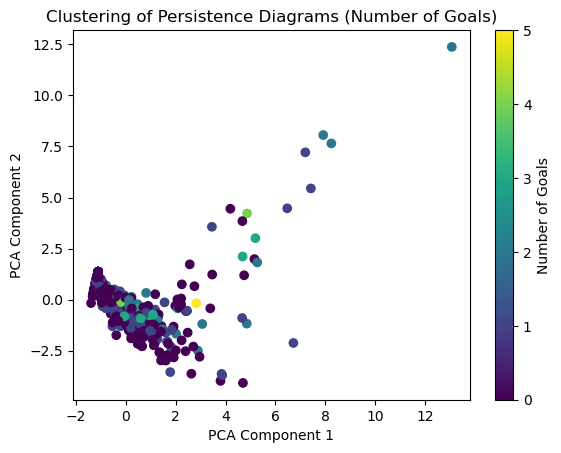

Match 1 - Goals Scored: 0
Match 2 - Goals Scored: 0
Match 3 - Goals Scored: 0
Match 4 - Goals Scored: 0
Match 5 - Goals Scored: 0
Match 6 - Goals Scored: 1
Match 7 - Goals Scored: 0
Match 8 - Goals Scored: 2
Match 9 - Goals Scored: 0
Match 10 - Goals Scored: 0
Match 11 - Goals Scored: 0
Match 12 - Goals Scored: 1
Match 13 - Goals Scored: 0
Match 14 - Goals Scored: 0
Match 15 - Goals Scored: 3
Match 16 - Goals Scored: 0
Match 17 - Goals Scored: 0
Match 18 - Goals Scored: 2
Match 19 - Goals Scored: 0
Match 20 - Goals Scored: 0
Match 21 - Goals Scored: 1
Match 22 - Goals Scored: 1
Match 23 - Goals Scored: 0
Match 24 - Goals Scored: 0
Match 25 - Goals Scored: 0
Match 26 - Goals Scored: 1
Match 27 - Goals Scored: 2
Match 28 - Goals Scored: 0
Match 29 - Goals Scored: 0
Match 30 - Goals Scored: 0
Match 31 - Goals Scored: 1
Match 32 - Goals Scored: 2
Match 33 - Goals Scored: 0
Match 34 - Goals Scored: 1
Match 35 - Goals Scored: 0
Match 36 - Goals Scored: 0
Match 37 - Goals Scored: 1
Match 38 -

In [86]:
import re  # For regex to extract goals and time from filenames

# Extract goals and time from filenames
def extract_goals_and_time(file_path):
    filename = os.path.basename(file_path)
    match = re.match(r"\d+_([A-Za-z\-]+)_(\d+)_(\d+).json", filename)
    if match:
        team = match.group(1)
        goals = int(match.group(2))
        time = int(match.group(3))
        adjusted_goals = goals * (60 / time)  # Scale goals to a 60-minute match
        return goals, adjusted_goals, time
    else:
        return None, None, None

# Load the data from the files and extract goal/time info
folder_path = '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/'

# Get a list of all files in the folder
file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith('.json')]

# Load all files
data = [json.load(open(file_path)) for file_path in file_paths]

goal_info = [extract_goals_and_time(file_path) for file_path in file_paths]

# Construct passing networks and compute persistence diagrams
persistence_diagrams = []
for match_data in data:
    G = construct_adjacency_matrix(match_data)
    adj_matrix = nx.to_numpy_array(G)
    persistence_diagrams.append(ripser(adj_matrix, distance_matrix=True)['dgms'])

# Extract features from persistence diagrams
def extract_features(persistence_diagrams):
    features = []
    max_len = 0
    for diagram in persistence_diagrams:
        if diagram:
            diagram = np.array(diagram[0])
            lifespan = diagram[:, 1] - diagram[:, 0]
            features.append(lifespan)
            max_len = max(max_len, len(lifespan))
        else:
            features.append(np.zeros(1))
    
    padded_features = []
    for feature in features:
        if len(feature) < max_len:
            padded_features.append(np.pad(feature, (0, max_len - len(feature)), mode='constant'))
        else:
            padded_features.append(feature)
    
    return np.array(padded_features)

# Extract features and check for NaN or infinity
features = extract_features(persistence_diagrams)

# Handle NaN or infinity values before scaling
if np.any(np.isnan(features)) or np.any(np.isinf(features)):
    print("Features contain NaN or Infinity values.")
    features = np.nan_to_num(features, nan=0, posinf=0, neginf=0)

# Standardize the features after handling NaN/Infinity
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA for dimensionality reduction
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Perform clustering
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(features_pca)

# Replace cluster label with number of goals scored
goals_labels = []
for i in range(len(goal_info)):
    goals, adjusted_goals, time = goal_info[i]
    if goals is not None:
        goals_labels.append(goals)
    else:
        goals_labels.append(0)  # In case there's no goal information, use 0

# Visualize the clustering results with number of goals as the label
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=goals_labels, cmap='viridis')
plt.title("Clustering of Persistence Diagrams (Number of Goals)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Number of Goals")
plt.show()

# Output the number of goals associated with each cluster
for i, goals in enumerate(goals_labels):
    print(f"Match {i+1} - Goals Scored: {goals}")


Features contain NaN or Infinity values.


/Users/lliu001/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


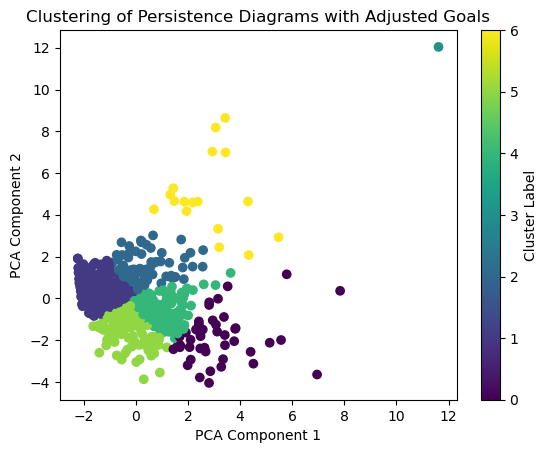

In [87]:
# Function to adjust goals based on match time
def adjust_goals(goals, time):
    return (goals / time) * 60  # Scale to a 60-minute match

# Function to parse the filename and extract team, goals, and time
def parse_filename(filename):
    parts = filename.split('_')
    team_name = parts[1]
    goals = int(parts[2])
    time = int(parts[3].replace('.json', ''))
    return team_name, goals, time

# Construct adjacency matrix and include adjusted goals
def construct_adjacency_matrix(game_data, adjusted_goals):
    G = nx.Graph()

    # Step 1: Find the maximum pass count to normalize edge weights
    max_count = max(pass_info["count"] for player in game_data for pass_info in player.get("passes", []))

    # Step 2: Add nodes for each player, including their adjusted goals
    for player in game_data:
        G.add_node(player['name'], pos=(player['x'], player['y']), adjusted_goals=adjusted_goals)
    
    # Step 3: Add edges with normalized weights (divide by max_count)
    for player in game_data:
        for pass_info in player.get("passes", []):
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]
            # Normalize edge weight by dividing by the max pass count
            edge_weight = count / max_count

            # Add edge to the graph with normalized weight
            G.add_edge(player1, player2, weight=edge_weight)

    return G

# Load data from files and construct persistence diagrams
folder_path = '/Users/lliu001/Desktop/Fall 2024/Math 412/TDA-1/data/2015-2016/1-Bundesliga/'

# Get a list of all files in the folder
file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith('.json')]

# Load all files
data = [json.load(open(file_path)) for file_path in file_paths]

# Load all match data and construct persistence diagrams
data = []
max_feature_length = 0  # Track the maximum length of features

for file_path in file_paths:
    team_name, goals, time = parse_filename(file_path)
    adjusted_goals = adjust_goals(goals, time)
    
    # Load the game data
    with open(file_path, 'r') as f:
        game_data = json.load(f)
    
    # Construct the adjacency matrix with adjusted goals
    G = construct_adjacency_matrix(game_data, adjusted_goals)
    
    # Convert graph to adjacency matrix and calculate persistence diagram
    adj_matrix = nx.to_numpy_array(G)
    persistence_diagrams = ripser(adj_matrix, distance_matrix=True)['dgms']
    
    # Extract features from persistence diagrams
    features = []
    for diagram in persistence_diagrams:
        # Ensure the diagram is not empty
        if diagram.size > 0:  
            diagram = np.array(diagram)  # Diagram contains points
            lifespan = diagram[:, 1] - diagram[:, 0]  # Calculate lifespan (death - birth)
            features.append(lifespan)
            max_feature_length = max(max_feature_length, len(lifespan))  # Update the max feature length
        else:
            features.append(np.zeros(1))  # Empty diagram, append a zero vector

    data.append(features)

# Pad the features to ensure they are of equal length
padded_data = []
for feature in data:
    padded_feature = []
    for f in feature:
        # Pad with zeros to the maximum feature length
        padded_feature.append(np.pad(f, (0, max_feature_length - len(f)), mode='constant'))
    padded_data.append(np.array(padded_feature))

# Convert to a numpy array and standardize the features
features = np.array(padded_data)
scaler = StandardScaler()

# Check for NaN or infinity values
if np.any(np.isnan(features)) or np.any(np.isinf(features)):
    print("Features contain NaN or Infinity values.")
    features = np.nan_to_num(features, nan=0, posinf=0, neginf=0)

features_scaled = scaler.fit_transform(features.reshape(features.shape[0], -1))  # Flatten for scaling

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=7, random_state=42)
cluster_labels = kmeans.fit_predict(features_pca)

# Visualize the clustering results
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title("Clustering of Persistence Diagrams with Adjusted Goals")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster Label")
plt.show()
